In [1]:
!pip install pandas transformers seaborn imblearn tqdm nltk sentence_transformers 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 135.1 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 146.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 115.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 171.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 KB 112.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 KB 120.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 KB 101.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 KB 96.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 230.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.7/781.7 KB 152.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 156.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 KB 56.4 MB/s eta 0:00:00
   

In [2]:
# reading the dataset
import json
import pandas as pd
df = pd.read_json("tmdb_movies_combined.json")
df.head()

,id,title,overview,poster_url,primary_genre
0,9355,Mad Max Beyond Thunderdome,Mad Max becomes a pawn in a decadent oasis of ...,https://image.tmdb.org/t/p/w500/jJlxcEVVUHnrUe...,Action
1,707,A View to a Kill,A newly-developed microchip designed by Zorin ...,https://image.tmdb.org/t/p/w500/arJF829RP9cYvh...,Others
2,1369,Rambo: First Blood Part II,John Rambo is released from prison by the gove...,https://image.tmdb.org/t/p/w500/pzPdwOitmTleVE...,Action
3,9846,To Live and Die in L.A.,When his longtime partner on the force is kill...,https://image.tmdb.org/t/p/w500/2iW3pSihBIhXjn...,Others
4,9056,Police Story,Officer Chan Ka Kui manages to put a major Hon...,https://image.tmdb.org/t/p/w500/q8YfsyX59OmoSD...,Action


In [3]:
# checking for dataset shape
print("Number of rows: ", df.shape[0])
print("Number of columns: ", df.shape[1])
# looking for redundant records
print("Number of duplicate records:", int(df.duplicated(keep = "first").sum()))

Number of rows:  103212
Number of columns:  5
Number of duplicate records: 0


In [4]:
# dropping duplicate records
df.drop_duplicates(keep = "first", inplace = True)
df.head()

,id,title,overview,poster_url,primary_genre
0,9355,Mad Max Beyond Thunderdome,Mad Max becomes a pawn in a decadent oasis of ...,https://image.tmdb.org/t/p/w500/jJlxcEVVUHnrUe...,Action
1,707,A View to a Kill,A newly-developed microchip designed by Zorin ...,https://image.tmdb.org/t/p/w500/arJF829RP9cYvh...,Others
2,1369,Rambo: First Blood Part II,John Rambo is released from prison by the gove...,https://image.tmdb.org/t/p/w500/pzPdwOitmTleVE...,Action
3,9846,To Live and Die in L.A.,When his longtime partner on the force is kill...,https://image.tmdb.org/t/p/w500/2iW3pSihBIhXjn...,Others
4,9056,Police Story,Officer Chan Ka Kui manages to put a major Hon...,https://image.tmdb.org/t/p/w500/q8YfsyX59OmoSD...,Action


<Axes: >

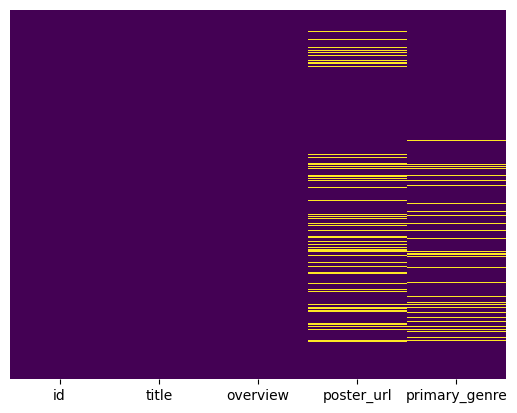

In [5]:
# checking for missing values
import seaborn as sns
sns.heatmap(df.isna(), cbar = False, yticklabels = False, cmap = "viridis")

In [6]:
# removing missing values
df.dropna(inplace = True)
df.head(3)

,id,title,overview,poster_url,primary_genre
0,9355,Mad Max Beyond Thunderdome,Mad Max becomes a pawn in a decadent oasis of ...,https://image.tmdb.org/t/p/w500/jJlxcEVVUHnrUe...,Action
1,707,A View to a Kill,A newly-developed microchip designed by Zorin ...,https://image.tmdb.org/t/p/w500/arJF829RP9cYvh...,Others
2,1369,Rambo: First Blood Part II,John Rambo is released from prison by the gove...,https://image.tmdb.org/t/p/w500/pzPdwOitmTleVE...,Action


Value Counts:
 primary_genre
Others         18469
Drama          15033
Comedy         10306
Documentary     9762
Action          9754
Horror          8984
Animation       8570
Name: count, dtype: int64


<Axes: xlabel='primary_genre'>

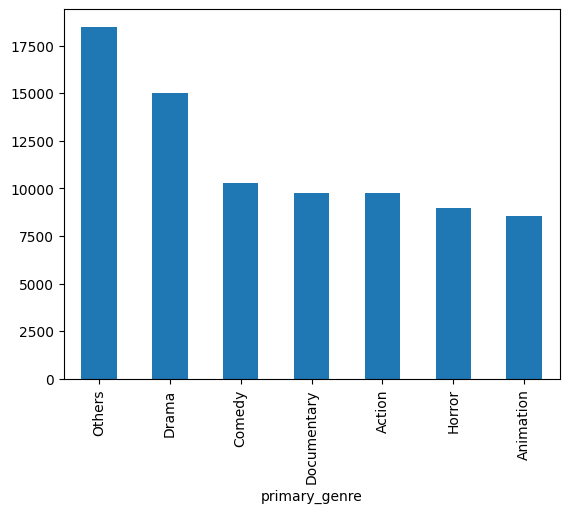

In [7]:
# checking for value counts in primary_genre
print("Value Counts:\n", df["primary_genre"].value_counts())
df["primary_genre"].value_counts().plot(kind = "bar")

In [8]:
# Drop the "others" genre as it was messing with acuracy
mask = ~df["primary_genre"].str.lower().eq("others")
df   = df.loc[mask].reset_index(drop=True)
print(f"New dataset size : {len(df):,} movies")


New dataset size : 62,409 movies


<Axes: xlabel='primary_genre'>

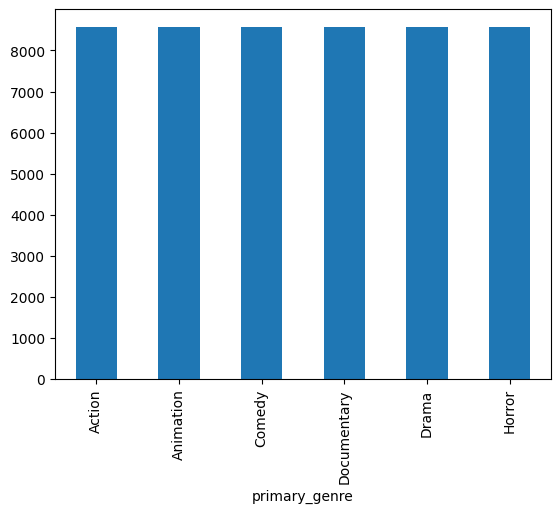

In [9]:
# performing random undersampling
from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler()
newDf, target = undersampler.fit_resample(df.drop("primary_genre", axis = 1), df["primary_genre"])
df = pd.concat([newDf, target], axis = 1)
df["primary_genre"].value_counts().plot(kind = "bar")

In [10]:
# analyzing description texts
df['overview'].head(3)

23349    When the night falls, and the creatures of the...
4645     Tara McCormick is sent to prison for the attem...
1858     Pudhea Paadhai is a 1989 Tamil film directed b...
Name: overview, dtype: object

In [11]:
# setting up NLTK
import nltk
nltk.download("punkt")
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [12]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
nltk.download("wordnet")
lemmatizer = WordNetLemmatizer()

def cleanText(text: str):
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator).lower()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(tokens)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [13]:
df["overview"] = df["overview"].apply(cleanText)

count    51420.000000
mean        26.393096
std         19.294954
min          0.000000
25%         13.000000
50%         21.000000
75%         36.000000
max        162.000000
Name: overview, dtype: float64

[Text(0.5, 1.0, 'Distribution of Token Counts of Descriptions')]

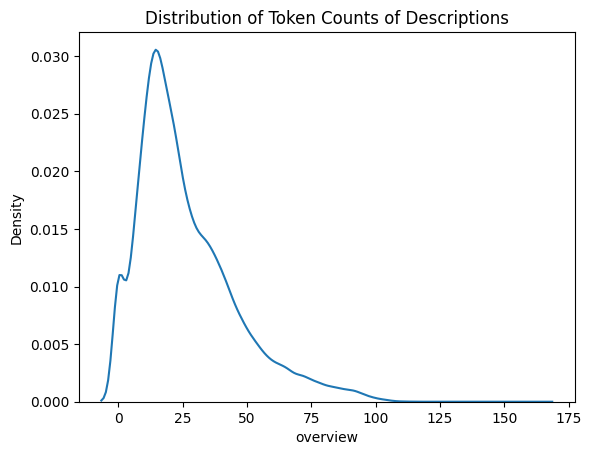

In [14]:
# checking for distribution of word tokens present in the descriptions
tokenCounts = df["overview"].apply(lambda x: len(nltk.word_tokenize(text = x)))
display(tokenCounts.describe())
display(sns.kdeplot(x = tokenCounts).set(title = "Distribution of Token Counts of Descriptions"))

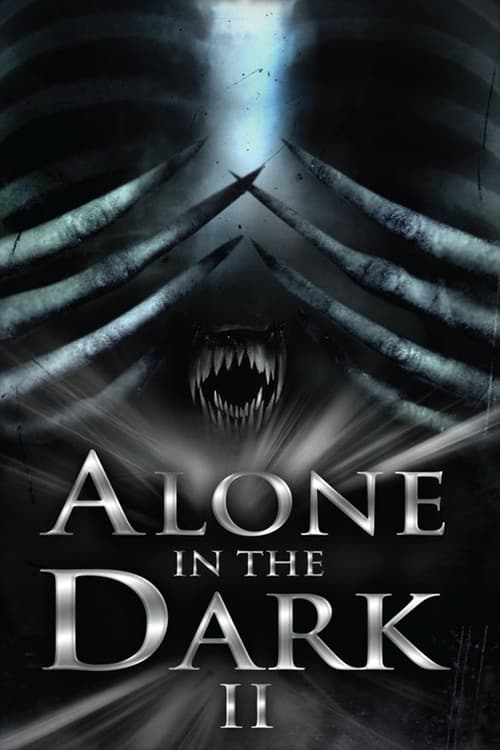

In [15]:
# checking for a sample image
import requests
from PIL import Image
import io
Image.open(io.BytesIO(requests.get(df["poster_url"].iloc[0]).content))

In [16]:
df.head()


,id,title,overview,poster_url,primary_genre
23349,12683,Alone in the Dark 2,night fall creature dark crawling shadow one m...,https://image.tmdb.org/t/p/w500/dGKQoqyYnleFrz...,Action
4645,28126,Fugitive Rage,tara mccormick sent prison attempted murder lo...,https://image.tmdb.org/t/p/w500/4hmwjp3tHruxE3...,Action
1858,281807,Pudhea Paadhai,pudhea paadhai 1989 tamil film directed r part...,https://image.tmdb.org/t/p/w500/bIz3sAoCV3yuyP...,Action
470,118224,Final Score,richard brown decorated vietnam war veteran li...,https://image.tmdb.org/t/p/w500/9AwXMkmLJMkm9J...,Action
21298,9381,Babylon A.D.,veteranturnedmercenary hired take young woman ...,https://image.tmdb.org/t/p/w500/bQqb3T0FIHOvgo...,Action


In [17]:
import requests
from PIL import Image
import io
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

def url_to_image(url: str) -> Image.Image | None:
    try:
        response = requests.get(url, timeout=5)
        response.raise_for_status()
        return Image.open(io.BytesIO(response.content))
    except Exception:
        return None

def fetch_all_images(urls: list[str], max_workers: int = 20) -> list[Image.Image | None]:
    images = [None] * len(urls)
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(url_to_image, url): i for i, url in enumerate(urls)}
        for future in tqdm(as_completed(futures), total=len(futures), desc="Downloading images"):
            i = futures[future]
            try:
                images[i] = future.result()
            except Exception:
                images[i] = None
    return images

all_posters = fetch_all_images(df["poster_url"].tolist())

In [18]:
# using mixedbread-ai/mxbai-embed-large-v1 embeddings with embedding dimension as 1024
from sentence_transformers import SentenceTransformer
textEncoderModel = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1", truncate_dim = 1024).to("cuda")
textEmbeddings = textEncoderModel.encode(df["overview"].tolist(), normalize_embeddings=True)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/114k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

In [19]:
allPostersList     = list(all_posters)
textEmbeddingsList = list(textEmbeddings)
orig_indices       = list(range(len(allPostersList)))

# Filter out None entries and keep their df‐row indices
filtered = [
    (idx, p, e)
    for idx, (p, e) in zip(orig_indices, zip(allPostersList, textEmbeddingsList))
    if p is not None
]

# Unzip back into three lists
success_idx, allPostersList, textEmbeddingsList = zip(*filtered)
success_idx = list(success_idx)
allPostersList     = list(allPostersList)
textEmbeddingsList = list(textEmbeddingsList)


In [ ]:
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
from tqdm import tqdm
import torch

# setup
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50", trust_remote_code=True)
model = AutoModel.from_pretrained("microsoft/resnet-50", trust_remote_code=True).to("cuda")
model.eval()


# generating embeddings
embeddings = []
with torch.inference_mode():
    for img in tqdm(allPostersList, desc="IMAGES EMBEDDED:"):
        inputs = processor(images=img.convert("RGB"), return_tensors="pt").to("cuda")
        outputs = model(**inputs)
        embedding = outputs.last_hidden_state.mean(dim=(2, 3))
        embeddings.append(embedding.squeeze().cpu())


preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

IMAGES EMBEDDED::  15%|█▌        | 7831/51420 [01:57<10:31, 69.01it/s]

In [ ]:
# converting image embeddings to numpy arrays
import numpy as np
imageEmbeddings = np.array([np.array(embedding) for embedding in embeddings])

In [ ]:
print("imageEmbeddings shape:", imageEmbeddings.shape)   # expect (60000, 2048)
print("textEmbeddings  shape:", textEmbeddings.shape)    # expect (60000, 768)


In [ ]:
# ── Create y from your dataframe ───────────────────────────────────────
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["genre_id"] = le.fit_transform(df["primary_genre"])   # add new int column
y = df["genre_id"].values                                # 1-D numpy array

print("y shape:", y.shape)
print("class ↦ id mapping:", dict(zip(le.classes_, le.transform(le.classes_))))


In [ ]:
# === TEXT-ONLY LSTM CLASSIFIER =========================================
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

def train_lstm_text(X_text, y, epochs=15, hidden=256, batch=128, lr=1e-3):
    """
    X_text : np.ndarray  (N, seq_len, embed_dim)  OR  (N, embed_dim)
             If 2-D, we treat each vector as a sequence of length 1.
    y      : np.ndarray  integer labels
    """
    # Ensure 3-D: (N, seq_len, embed_dim)
    if X_text.ndim == 2:
        X_text = X_text[:, None, :]
    seq_len, embed_dim = X_text.shape[1], X_text.shape[2]
    n_classes          = int(y.max() + 1)

    Xtr, Xval, ytr, yval = train_test_split(
        X_text, y, test_size=0.2, random_state=42, stratify=y
    )

    ds_tr  = TensorDataset(torch.tensor(Xtr, dtype=torch.float32),
                           torch.tensor(ytr, dtype=torch.long))
    ds_val = TensorDataset(torch.tensor(Xval, dtype=torch.float32),
                           torch.tensor(yval, dtype=torch.long))
    dl_tr  = DataLoader(ds_tr,  batch_size=batch, shuffle=True)
    dl_val = DataLoader(ds_val, batch_size=batch)

    class TextLSTM(nn.Module):
        def __init__(self):
            super().__init__()
            self.lstm  = nn.LSTM(embed_dim, hidden, num_layers=2,
                                 batch_first=True, dropout=0.3, bidirectional=False)
            self.fc    = nn.Linear(hidden, n_classes)
        def forward(self, x):
            _, (h_n, _) = self.lstm(x)           # h_n shape: (num_layers, B, hidden)
            out = self.fc(h_n[-1])               # use last layer’s hidden state
            return out

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = TextLSTM().to(device)
    opt    = torch.optim.AdamW(model.parameters(), lr=lr)
    crit   = nn.CrossEntropyLoss()

    for epoch in range(1, epochs + 1):
        model.train()
        for xb, yb in dl_tr:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = crit(model(xb), yb)
            loss.backward()
            opt.step()
        if epoch % 5 == 0 or epoch == epochs:
            model.eval()
            all_pred, all_true = [], []
            with torch.no_grad():
                for xb, yb in dl_val:
                    xb = xb.to(device)
                    pred = model(xb).argmax(1).cpu()
                    all_pred.extend(pred)
                    all_true.extend(yb)
            print(f"[Epoch {epoch}] val acc = "
                  f"{(torch.tensor(all_pred) == torch.tensor(all_true)).float().mean():.4f}")

    print("\nTEXT-ONLY LSTM – validation report")
    print(classification_report(all_true, all_pred))

    print("Confusion Matrix (rows = true, cols = pred):")
    cm = confusion_matrix(all_true, all_pred)
    print(cm)

    labels = le.classes_
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix (Text-LSTM)")
    plt.tight_layout()
    plt.show()
    
    return model

lstm_text_model = train_lstm_text(textEmbeddings, y)


In [ ]:
# === IMAGE-ONLY MLP CLASSIFIER =========================================
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report

def train_mlp_image(X_img, y, epochs=20, batch=256, lr=1e-3):
    """
    X_img : np.ndarray  (N, embed_dim)
    y     : np.ndarray  integer labels
    """
    in_dim       = X_img.shape[1]
    n_classes    = int(y.max() + 1)

    Xtr, Xval, ytr, yval = train_test_split(
        X_img, y, test_size=0.2, random_state=42, stratify=y
    )

    ds_tr  = TensorDataset(torch.tensor(Xtr, dtype=torch.float32),
                           torch.tensor(ytr, dtype=torch.long))
    ds_val = TensorDataset(torch.tensor(Xval, dtype=torch.float32),
                           torch.tensor(yval, dtype=torch.long))
    dl_tr  = DataLoader(ds_tr,  batch_size=batch, shuffle=True)
    dl_val = DataLoader(ds_val, batch_size=batch)

    class ImageMLP(nn.Module):
        def __init__(self):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(in_dim, 512),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, n_classes)
            )
        def forward(self, x): return self.net(x)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = ImageMLP().to(device)
    opt    = torch.optim.AdamW(model.parameters(), lr=lr)
    crit   = nn.CrossEntropyLoss()

    for epoch in range(1, epochs + 1):
        model.train()
        for xb, yb in dl_tr:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = crit(model(xb), yb)
            loss.backward()
            opt.step()
        if epoch % 5 == 0 or epoch == epochs:
            model.eval()
            all_pred, all_true = [], []
            with torch.no_grad():
                for xb, yb in dl_val:
                    xb = xb.to(device)
                    pred = model(xb).argmax(1).cpu()
                    all_pred.extend(pred)
                    all_true.extend(yb)
            print(f"[Epoch {epoch}] val acc = "
                  f"{(torch.tensor(all_pred) == torch.tensor(all_true)).float().mean():.4f}")

    print("\nIMAGE-ONLY MLP – validation report")
    print(classification_report(all_true, all_pred))

    print("Confusion Matrix (rows = true, cols = pred):")
    cm = confusion_matrix(all_true, all_pred)
    print(cm)

    labels = le.classes_
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix (Image-MLP)")
    plt.tight_layout()
    plt.show()

    return model
X_img = imageEmbeddings

y_img = y[success_idx] # align with embeddings
assert len(X_img) == len(y_img)
mlp_image_model = train_mlp_image(X_img, y_img)


In [ ]:
# stacking images and text embeddings horizontally
embeddings = np.hstack((imageEmbeddings, textEmbeddings))

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df["primary_genre"] = encoder.fit_transform(df["primary_genre"])

In [ ]:
# using a train-test-split for confusion matrix
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(embeddings, df["primary_genre"], test_size=0.20, random_state=10)

In [ ]:
# standardizing the inputs
# Convert to torch tensors first
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

# Compute mean and std from training data
mean = x_train_tensor.mean(dim=0, keepdim=True)
std = x_train_tensor.std(dim=0, keepdim=True)

# Avoid division by zero
std[std == 0] = 1

# Normalize
x_train_tensor = (x_train_tensor - mean) / std
x_test_tensor = (x_test_tensor - mean) / std

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

# Convert data to tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create datasets and dataloaders
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

num_classes = len(np.unique(y_train))     
print("Num classes:", num_classes)        

# Define the PyTorch ANN model
class GenreClassifier(nn.Module):
    def __init__(self, input_dim):
        super(GenreClassifier, self).__init__()

        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(64, 32)
        self.bn4 = nn.BatchNorm1d(32)
        self.dropout4 = nn.Dropout(0.3)

        self.output = nn.Linear(32, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.dropout4(x)
        return F.log_softmax(self.output(x), dim=1)


# Instantiate and train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GenreClassifier(x_train.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.NLLLoss()

train_losses = []
train_accuracies = []
val_accuracies = []

best_val_acc = 0
patience = 5
wait = 0

for epoch in range(50):
    model.train()
    total_loss = 0
    correct = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (preds.argmax(dim=1) == yb).sum().item()

    train_acc = correct / len(train_loader.dataset)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    correct = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            correct += (preds.argmax(dim=1) == yb).sum().item()

    val_acc = correct / len(test_loader.dataset)
    val_accuracies.append(val_acc)
    train_losses.append(total_loss)

    print(f"Epoch {epoch+1:2d} | Loss: {total_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("⏹ Early stopping triggered.")
            break

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ANN Accuracy over Epochs')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:


epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Loss over epochs
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions for test set
model.eval()
all_preds = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        preds = model(xb)
        all_preds.append(preds.cpu().numpy())

predicted = np.argmax(np.vstack(all_preds), axis=1)
cm = confusion_matrix(y_test, predicted)

labels = le.classes_
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (ANN)")
plt.tight_layout()
plt.show()


In [ ]:
model.eval()
correct = 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        correct += (preds.argmax(dim=1) == yb).sum().item()

final_acc = correct / len(test_loader.dataset)
print(f"Final Test Accuracy: {final_acc:.4f}")
